# Group27 - Benedetto & Collura

2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

<div class="alert alert-warning">
We just implement the definition of euclidean distance, according to the formula:
<br>
$d(\textbf{p1},\textbf{p2}) = \sqrt{\sum_{i=1}^{n}{(q_i-p_i)^2}}$
<br>
Where p1 and p2 are two n-dimensional points.
</div>

In [1]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([(x1 - x2)**2 for (x1, x2) in zip(p1, p2)]))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

<div class="alert alert-warning">
We have to loop over all the centroids and compute the distance between each of them and the given point. Then we take the one with lowest distance.
</div>

In [2]:
import sys

def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    min_dist = sys.maxsize
    min_i = -1
    for i in np.arange(len(centroids)):
        dist = euclidean_distance(datapoint, centroids[i])
        if dist < min_dist:
            min_dist = dist
            min_i = i
    return min_i

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [3]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = data
    np.random.shuffle(centroids)
    return centroids[:k]

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), np.array([1,2,1]), np.array([3,1,2]) 
             ]), 2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

<div class="alert alert-warning">
The algorithm stop when one of these two conditions occurs:
<ul>
<li>We reach the max number of iterations;</li>
<li>The movement of the centroids is lower or equal than a certain threshold. If we set 0 as threshold (it is the default value) we require that the centroids do not move anymore. </li>
</ul>
</div>

In [4]:
MAX_ITERATIONS = 1000

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations >= MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    dist = 0
    for c1, c2 in zip(centroids, old_centroids):
        dist += euclidean_distance(c1, c2)
    if dist < threshold:
        return True
    return False

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

<div class="alert alert-warning">
For each cluster, the new position of the centroid is computed performing the mean of the positions of all the points of the cluster.
</div>

In [5]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    
    new_centroids = []
    for i in range(len(centroids)):
        new_centroids.append( list(np.average(cluster[i],axis=0)) )
    
    return new_centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

<div class="alert alert-warning">
The k-means algorithm is quite simple from the logical point of view: starting from the initial set of centroids (that can be given or generated ranomly), it assigns each point to the closest cluster and updates the centroids looping until one of the termination conditions is met.
</div>

In [6]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for point in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(point, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(point)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, 0.1):
            break
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


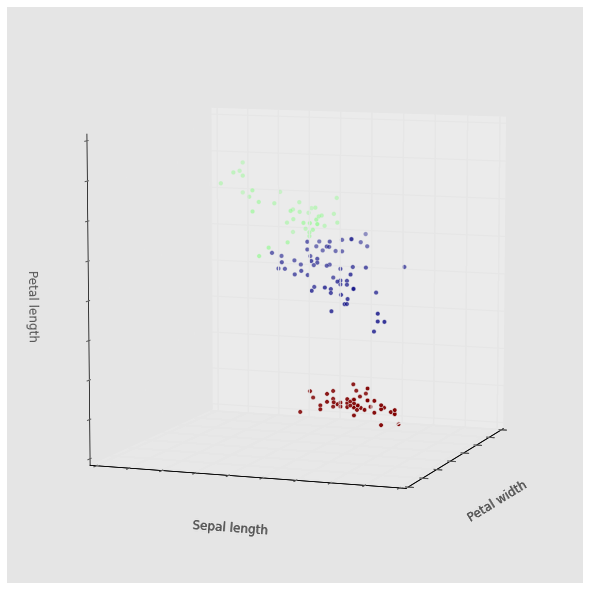

In [16]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

<div class="alert alert-warning">
In this case it looks like we obtain a good result, since the clusters appear to be well defined and separated. The problem is that we tries to run this cell many times and the clusters often changed, thus the algorithm is not actually good beacuse it leads to very different results (sometimes better, sometimes worse). Anyway, this is just one example, thus we decided to search for more datasets and apply the same clustering algorithm to all of them, to have an idea of the performances while working on data with different shapes.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


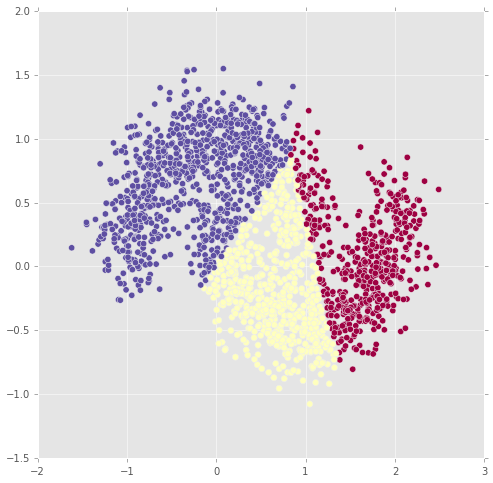

In [11]:
# moon
plt.figure(figsize=(8,8))
X, y = datasets.make_moons(2000, noise=0.2)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.show()

<div class="alert alert-warning">
In this case we can see the three clusters and they are not overlapping, but probably it doesn't make much sense the number of clusters we have chosen.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


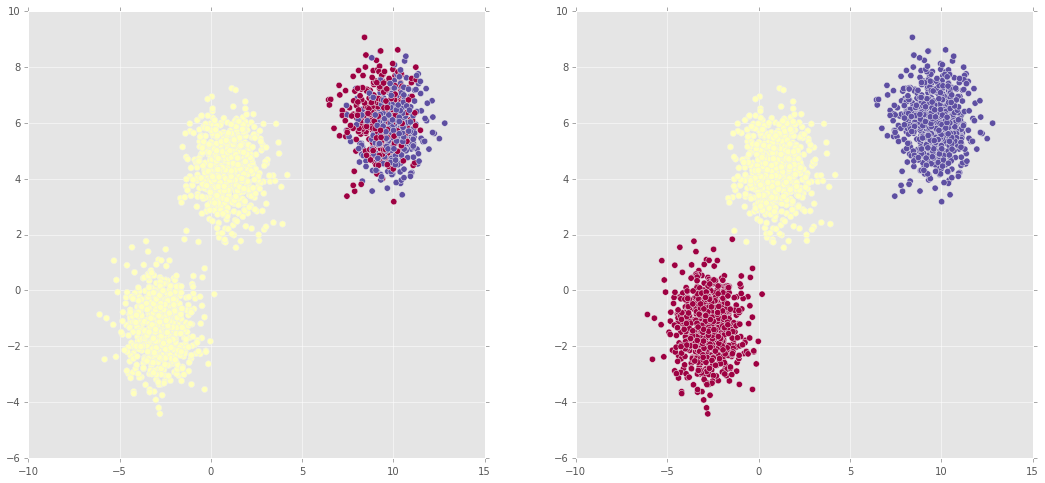

In [12]:
# blob
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.subplot(1,2,2)
np.random.seed(3)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-warning">
Here we can see two completely different behaviours: in the left one the clustering algorithm worked in a terrible way, leading to 1 big yellow and the red and blue clusters are overlapping. In the second case, on the other hand, it worked well and the three clusters are well defined.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


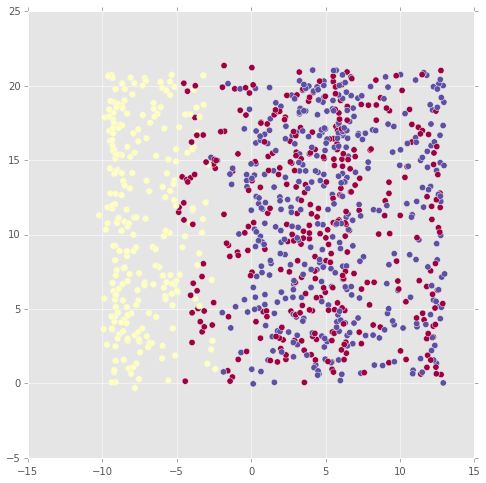

In [13]:
# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_

plt.figure(figsize=(8,8))
X, y = datasets.make_swiss_roll(1000, 0.3)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.show()



<div class="alert alert-warning">
In this case as well the result is really bad, we can see that the yellow cluster has been identified quite well, but the red one and blue one make no sense, since they are overlapping.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


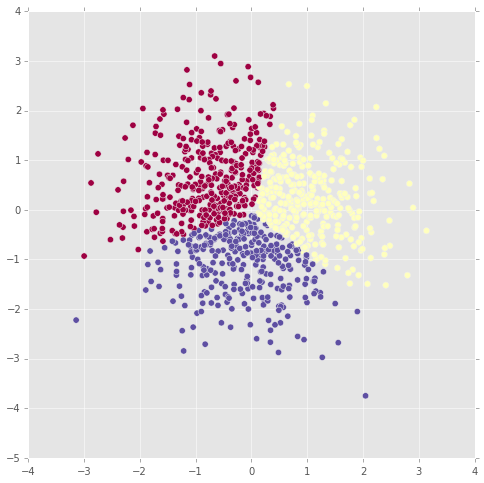

In [14]:
plt.figure(figsize=(8,8))
X, y = datasets.make_gaussian_quantiles(n_samples=1000)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.show()

<div class="alert alert-warning">
In this last case the algorithm worked quite well, we can see three different clusters and there aren't problems such as overlapping clusters or similar. In this case the value three maybe was not the most useful one though.
</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [7]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 8.0)

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

In [8]:
sqlContext = SQLContext(sc)
dataSchema = StructType([ \
    StructField('duration', IntegerType(), True), \
    StructField('protocol_type', StringType(), True), \
    StructField('service', StringType(), True), \
    StructField('flag', StringType(), True), \
    StructField('src_bytes', IntegerType(), True), \
    StructField('dst_bytes', IntegerType(), True), \
    StructField('land', StringType(), True), \
    StructField('wrong_fragment', IntegerType(), True), \
    StructField('urgent', IntegerType(), True), \
    StructField('hot', IntegerType(), True), \
    StructField('num_failed_logins', IntegerType(), True), \
    StructField('logged_in', StringType(), True), \
    StructField('num_compromised', IntegerType(), True), \
    StructField('root_shell', IntegerType(), True), \
    StructField('su_attempted', IntegerType(), True), \
    StructField('num_root', IntegerType(), True), \
    StructField('num_file_creations', IntegerType(), True), \
    StructField('num_shells', IntegerType(), True), \
    StructField('num_access_files', IntegerType(), True), \
    StructField('num_outbound_cmds', IntegerType(), True), \
    StructField('is_host_login', StringType(), True), \
    StructField('is_guest_login', StringType(), True), \
    StructField('count', IntegerType(), True), \
    StructField('srv_count', IntegerType(), True), \
    StructField('serror_rate', FloatType(), True), \
    StructField('srv_serror_rate', FloatType(), True), \
    StructField('rerror_rate', FloatType(), True), \
    StructField('srv_rerror_rate', FloatType(), True), \
    StructField('same_srv_rate', FloatType(), True), \
    StructField('diff_srv_rate', FloatType(), True), \
    StructField('srv_diff_host_rate', FloatType(), True), \
    StructField('dst_host_count', IntegerType(), True), \
    StructField('dst_host_srv_count', IntegerType(), True), \
    StructField('dst_host_same_srv_rate', FloatType(), True), \
    StructField('dst_host_diff_srv_rate', FloatType(), True), \
    StructField('dst_host_same_src_port_rate', FloatType(), True), \
    StructField('dst_host_srv_diff_host_rate', FloatType(), True), \
    StructField('dst_host_serror_rate', FloatType(), True), \
    StructField('dst_host_srv_serror_rate', FloatType(), True), \
    StructField('dst_host_rerror_rate', FloatType(), True), \
    StructField('dst_host_srv_rerror_rate', FloatType(), True), \
    StructField('type', StringType(), True) \
])

df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=',') \
    .load(input_path, schema = dataSchema) \
    .cache()

df.show(1)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

<div class="alert alert-warning">
Before moving to the clustering and the search for anomalies, could be useful to perform some data analysis to get a better insight of the data we're working on.
</div>

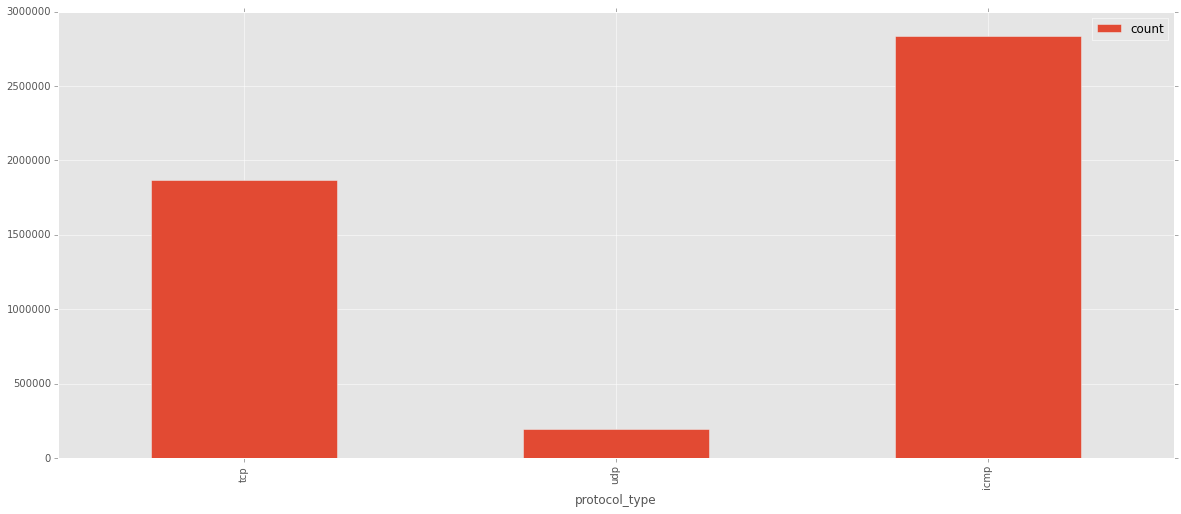

,protocol_type,count
0,tcp,1870598
1,udp,194288
2,icmp,2833545


In [34]:
protocol_types = df.groupBy('protocol_type').count().toPandas()
protocol_types.plot(kind='bar', x='protocol_type')
plt.show()
protocol_types

<div class="alert alert-warning">
From this first plot we can see that there are three protocols used in the dataset, and icmp is by far the most used, tcp is the second most used and, the least used is udp (around 4% of the entries is with udp).
</div>

In [35]:
# find interesting columns
descriptions = df.describe('duration', 'src_bytes', 'dst_bytes')
descriptions.show()

+-------+-----------------+------------------+------------------+
|summary|         duration|         src_bytes|         dst_bytes|
+-------+-----------------+------------------+------------------+
|  count|          4898431|           4898431|           4898431|
|   mean|48.34243046395876|1834.6211752293746|1093.6228137132073|
| stddev|723.3298112546695| 941431.0744911351| 645012.3337425147|
|    min|                0|                 0|                 0|
|    max|            58329|        1379963888|        1309937401|
+-------+-----------------+------------------+------------------+



<div class="alert alert-warning">
From this table we can immediately notice that we have some "problem", since we have as minimum value for all the three columns the value 0. If we think about it, we can guess that the duration can be 0 if there is no connection but only a single packet that has been sent (or maybe we could just have missing data...), while in the case of source and destination bytes the cause could be either missing data or a unidirectional connection.
</div>

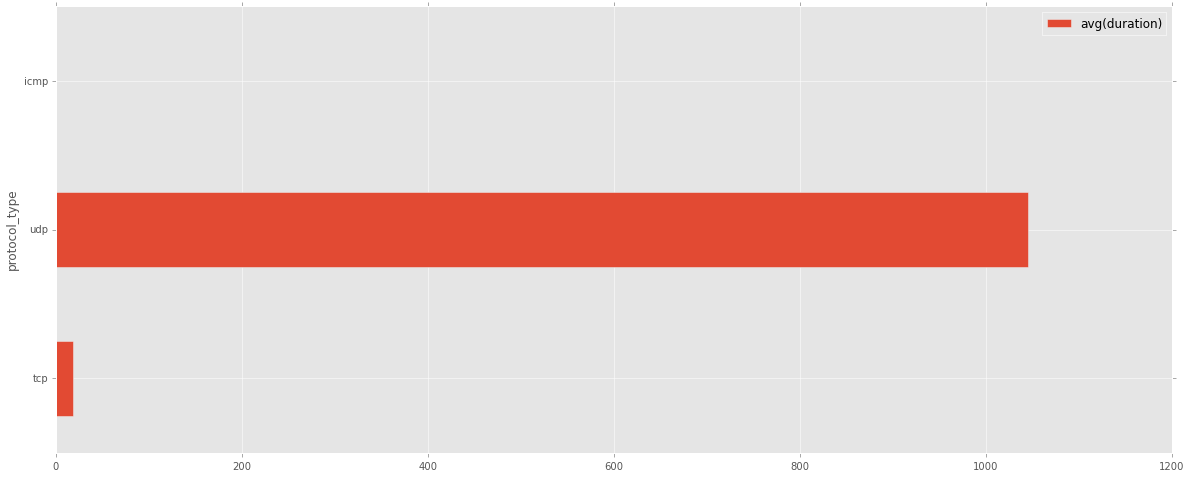

,protocol_type,avg(duration)
0,tcp,18.032538
1,udp,1045.203152
2,icmp,0.000000


In [36]:
protocol_types_duration = df.groupBy('protocol_type').mean('duration').toPandas()
protocol_types_duration.plot(kind='barh', x='protocol_type')
plt.show()
protocol_types_duration

<div class="alert alert-warning">
We can see that icmp has 0 as average and, since we are working on Integers, this means that all the ICMP messages have duration equal to 0. This makes sense since the ICMP protocol consists in an unidirectional packet sent from a source to a destination to send operational informations and error messages.
This is also confirming our expectations for the goodness of the value 0 as source or destination bytes.
<br><br>
If we focus on UDP and TCP, we see that the average duration of UDP is way bigger than the one of TCP. If we consider the behaviour of the protocols, this makes sense since UDP is a transaction-oriented protocol and therefore error checking and correction is performed at the application layer, causing worse performances compared to TCP. This one, indeed, is connection-oriented and guarantees that all the data sent from the source will reach the destination in the same order. This means that there is a check for lost packets at transport layer.
</div>

<div class="alert alert-info">
We are computing the average and by definition this operation puts everything in a single basket, thus we decided to plot the duration for each TCP and UDP connection, in order to see if there are certain connections that could affect the average in a relevant way.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


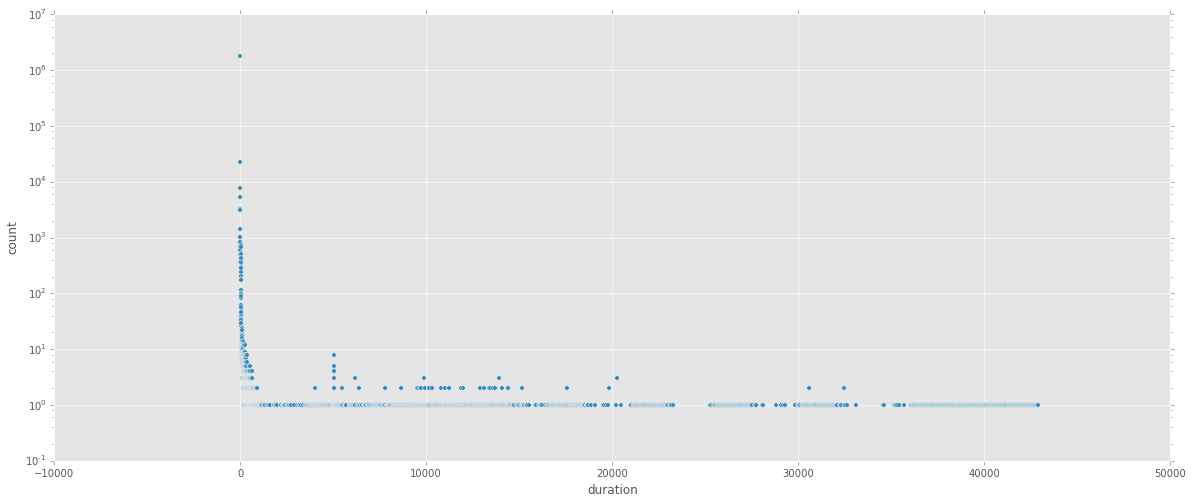

In [37]:
tcp_duration = df.filter(col('protocol_type') == 'tcp').groupBy('duration').count().orderBy('duration').toPandas()
tcp_duration.plot(x='duration', y='count', kind='scatter', logy=True)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


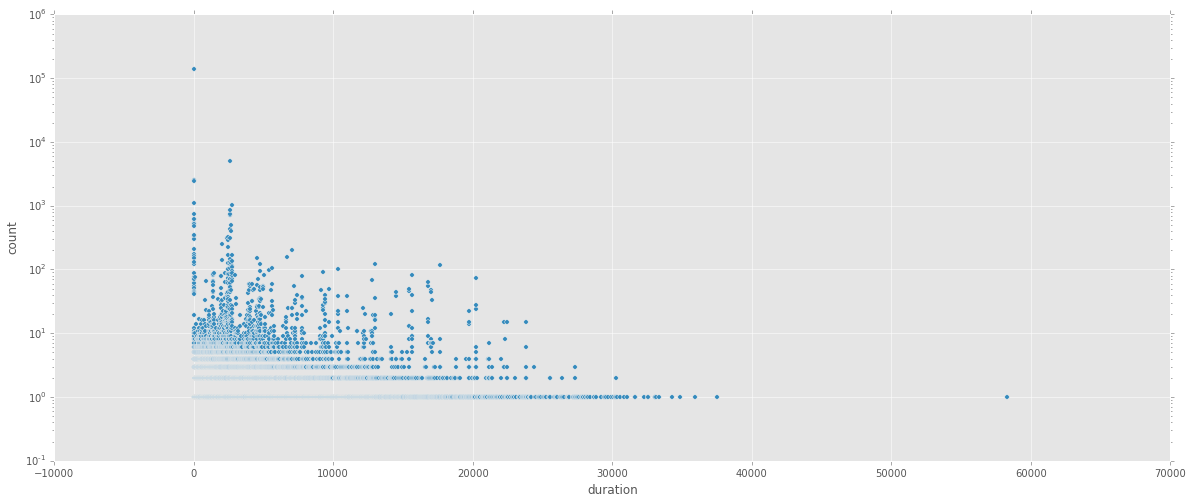

In [38]:
udp_duration = df.filter(col('protocol_type') == 'udp').groupBy('duration').count().orderBy('duration').toPandas()
udp_duration.plot(x='duration', y='count', kind='scatter', logy=True)
plt.show()

<div class="alert alert-info">
Now we can also look at the services, which are the most/least commonly used and which are the slowest/fastes. This could be useful later, while analyzing the attacks (maybe there are attacks that are aiming only at a service, etc...).
</div>

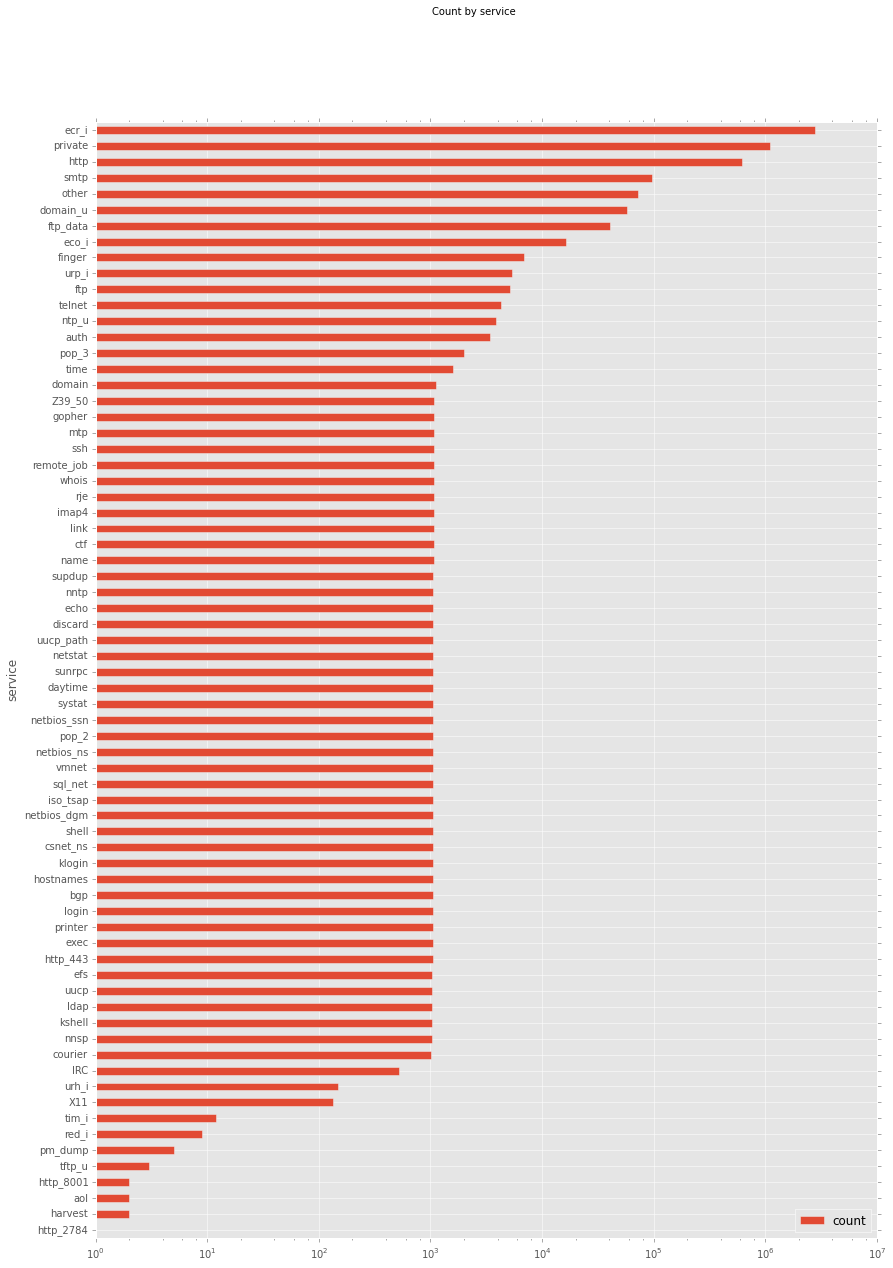

In [39]:
# services
fig, ax = plt.subplots(figsize=(14, 20))
fig.suptitle('Count by service')
services = df.groupBy('service').count().orderBy('count').toPandas()
services.plot(kind='barh', x='service', logx=True, ax=ax)
plt.show()

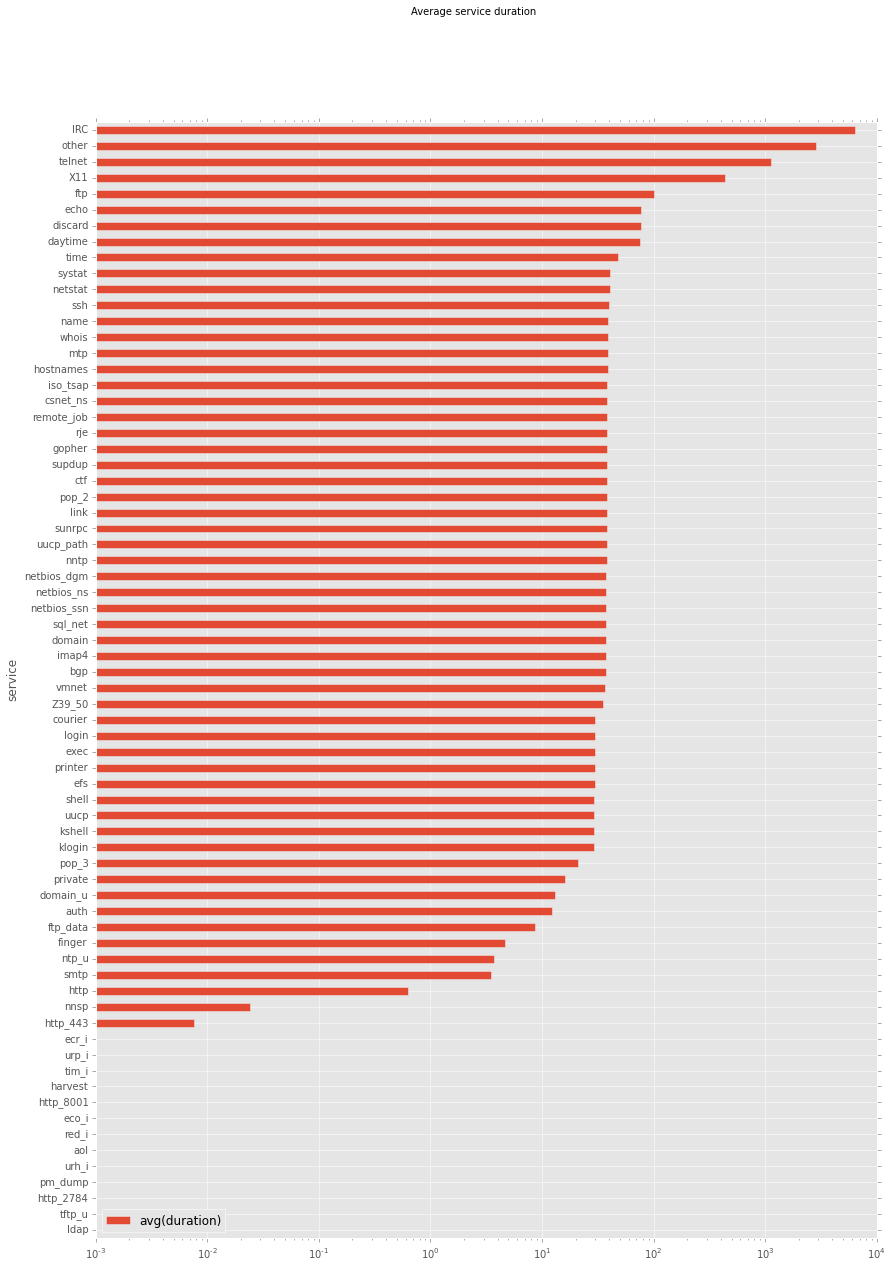

In [40]:
fig, ax = plt.subplots(figsize=(14, 20))
fig.suptitle('Average service duration')
service_duration = df.groupBy('service').mean('duration').orderBy('avg(duration)').toPandas()
service_duration.plot(kind='barh', x='service', logx=True, ax=ax)
plt.show()

<div class="alert alert-info">
The most important aspect to consider, anyway, is the analysis of the attack types and how they are oriented to the different protocols.
<br><br>
First of all let's show which attacks are the most common.
</div>

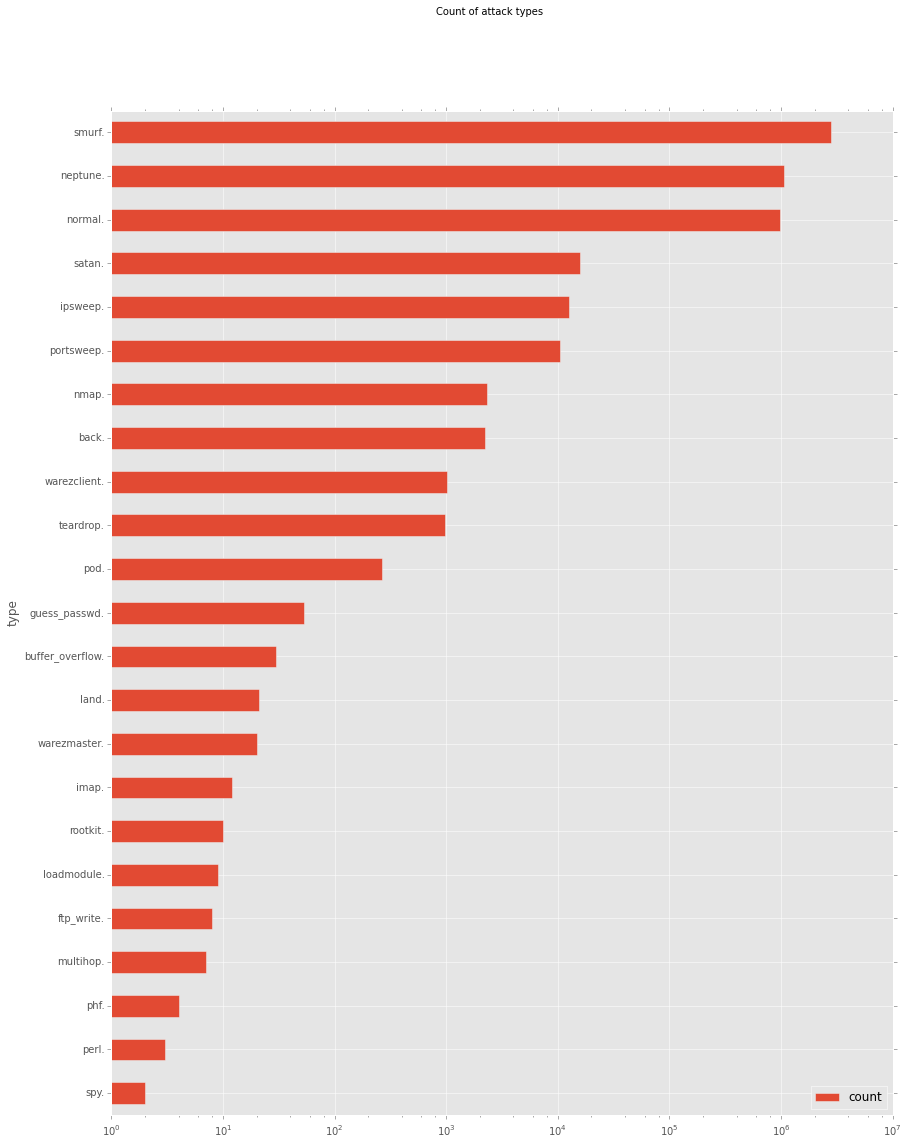

In [41]:
fig, ax = plt.subplots(figsize=(14, 18))
fig.suptitle('Count of attack types')
types = df.groupBy('type').count().orderBy('count').toPandas()
types.plot(kind='barh', x='type', ax=ax, logx=True)
plt.show()

<div class="alert alert-warning">
We can see that there are many different 22 types of attacks (we have 23 entries but one of them is not an attack, it's `normal`) and there are a couple of them that are way more common than the others (please notice that the x-axis is in log scale). `smurf` and `neptune` are the most common ones, and the gap between them and the third one is huge (almost $10^2$)
</div>

<div class="alert alert-warning">
All these types of attacks could be reduced to four cathegories in the following way:
<ol>
<li><b>Denial of Service Attack (DOS)</b>: In this category the attacker makes some computing or memory resources too busy or too full to handle legitimate request, or deny legitimate users access to machine.
<br>DOS contains the attacks: 'neptune',  'back',  'smurf',  'pod',  'land',  and 'teardrop'.</li>
<li><b>Users  to  Root  Attack  (U2R)</b>: In this category the attacker starts out with access to a normal user account on the system and is able to exploit some vulnerability to obtain root access to the system.
<br>U2R contains the attacks: 'buffer_overflow', 'loadmodule', 'rootkit' and 'perl'</li>
<li><b>Remote to Local Attack (R2L)</b>: In this category the attacker sends packets to machine over a network but who does not have an account on that machine and exploits some vulnerability to gain local access as a user of that machine.  <br>R2L contain the attacks: 'warezclient', 'multihop', 'ftp_write', 'imap', 'guess_passwd', 'warezmaster', 'spy' and 'phf'</li>
<li><b>Probing  Attack (PROBE)</b>: In this category the attacker attempt to gather information about network of computers for the apparent purpose of circumventing its security.
<br>PROBE contains the attacks: 'portsweep', 'satan', 'nmap', and 'ipsweep'</li>
</ol>
</div>

<div class="alert alert-info">
Therefore we can plot the number of attacks for each one of these three cathegories to see which is the most common.
</div>

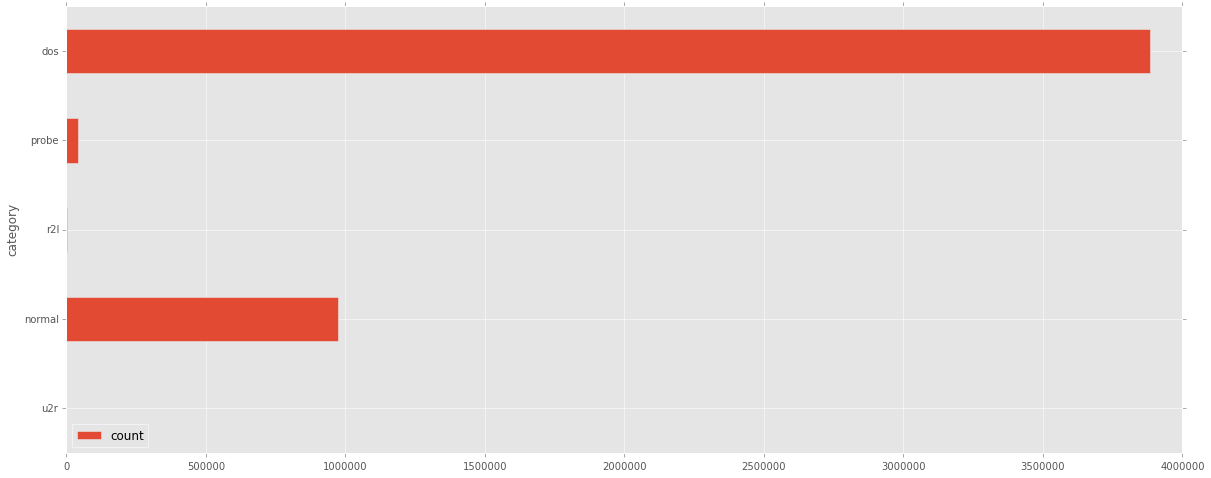

In [42]:
attack_categories = {
    'normal.': 'normal',
    'neptune.': 'dos', 'back.': 'dos', 'smurf.': 'dos', 'pod.': 'dos', 'land.': 'dos', 'teardrop.': 'dos',
    'buffer_overflow.': 'u2r', 'loadmodule.': 'u2r', 'rootkit.': 'u2r', 'perl.': 'u2r',
    'warezclient.': 'r2l', 'multihop.': 'r2l', 'ftp_write.': 'r2l', 'imap.': 'r2l', 'guess_passwd.': 'r2l', 'warezmaster.': 'r2l', 'spy.': 'r2l', 'phf.': 'r2l',
    'portsweep.': 'probe', 'satan.': 'probe', 'nmap.': 'probe', 'ipsweep.': 'probe'
}

attack_udf = udf(lambda atk_type: attack_categories[atk_type], StringType())
df_attack_cat = df.withColumn('category', attack_udf(col('type')))
attack_categories_count = df_attack_cat.groupBy('category').count().toPandas()
attack_categories_count.plot(kind='barh', x='category')
plt.show()

In [45]:
# percentuale di normal sul dataset
total = df.count()
attack_type_perc = df_attack_cat.groupBy('category').agg((count('*') / total * 100).alias('perc'))
attack_type_perc.show(truncate=False)

+--------+---------------------+
|category|perc                 |
+--------+---------------------+
|u2r     |0.0010615644070519723|
|normal  |19.859032412623552   |
|r2l     |0.022986952352702324 |
|probe   |0.8390850049740417   |
|dos     |79.27783406564265    |
+--------+---------------------+



<div class="alert alert-warning">
We can see that dos is by far the most common category of attack, and this makes sense since the most common types belong to this category.
</div>
<div class="alert alert-info">
Another interesting aspect to consider is how the different categories are aiming to different protocols, and we can plot this in two ways (grouping by category and grouping by protocol), we decided to do both the plots.
</div>

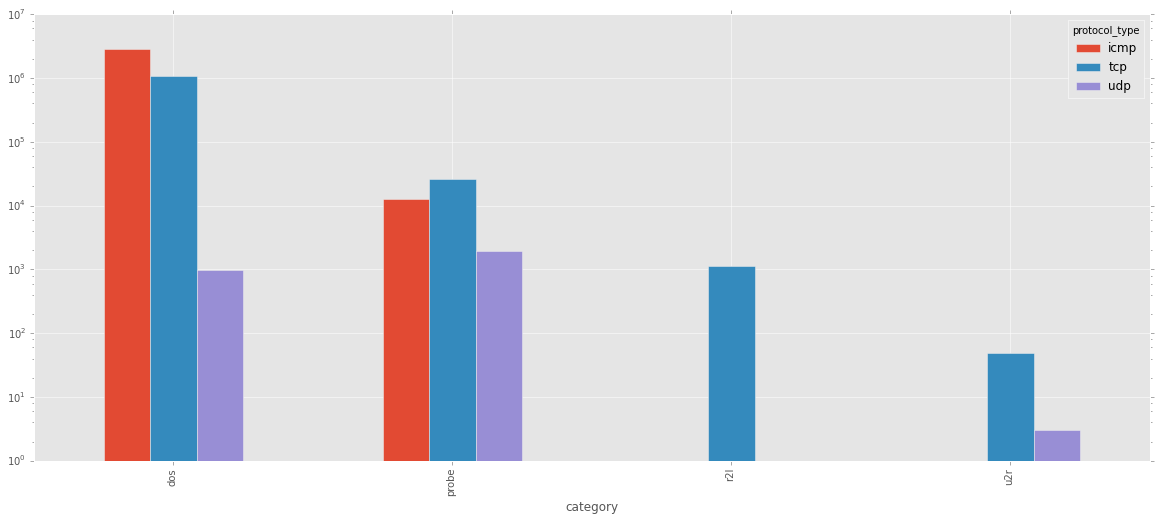

protocol_type,icmp,tcp,udp
category,,,
dos,2808150,1074241,979
probe,12632,26512,1958
r2l,NaN,1126,NaN
u2r,NaN,49,3


In [43]:
attack_type_categories = df_attack_cat.filter(col('category') != 'normal')\
                                      .groupBy('category', 'protocol_type')\
                                      .count().orderBy('category').toPandas()
attack_type_categories = attack_type_categories.pivot(index='category', columns='protocol_type', values='count')
attack_type_categories.plot(kind='bar', logy=True)
plt.show()

attack_type_categories

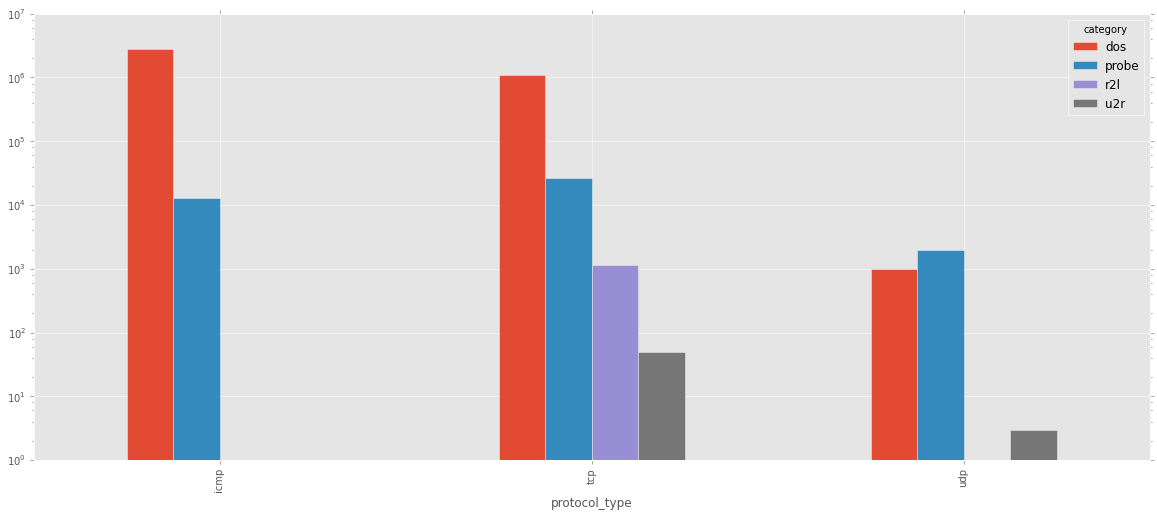

category,dos,probe,r2l,u2r
protocol_type,,,,
icmp,2808150,12632,NaN,NaN
tcp,1074241,26512,1126,49
udp,979,1958,NaN,3


In [44]:
attack_type_categories = df_attack_cat.filter(col('category') != 'normal')\
                                      .groupBy('category', 'protocol_type')\
                                      .count().orderBy('category').toPandas()
attack_type_categories = attack_type_categories.pivot(index='protocol_type', columns='category', values='count')
attack_type_categories.plot(kind='bar', logy=True)
plt.show()

attack_type_categories

<div class="alert alert-warning">
We can notice that ICMP has received only dos and probe attacks, and these two categories are the only ones that attacked all the protocols. Indeed, r2l attacks aimed only at TCP connections and u2r attacks never aimed at ICMP packets.
</div>
<div class="alert alert-info">
We can also make a similar plot, but taking into account the types instead of the categories.
</div>

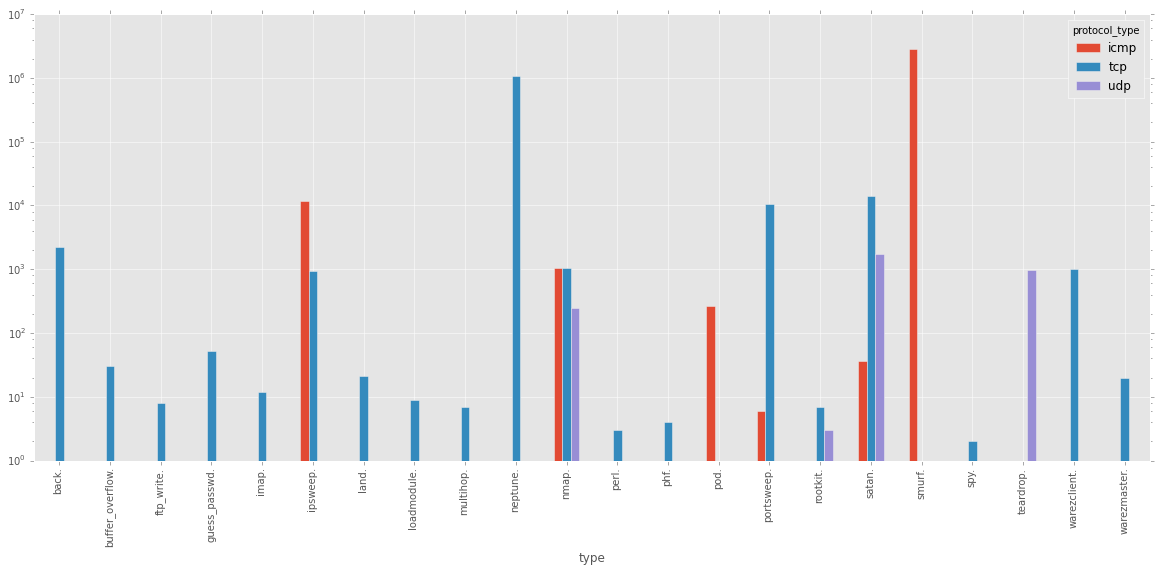

protocol_type,icmp,tcp,udp
type,,,
back.,NaN,2203,NaN
buffer_overflow.,NaN,30,NaN
ftp_write.,NaN,8,NaN
guess_passwd.,NaN,53,NaN
imap.,NaN,12,NaN
ipsweep.,11557,924,NaN
land.,NaN,21,NaN
loadmodule.,NaN,9,NaN
multihop.,NaN,7,NaN


In [46]:
attack_type_protocol = df_attack_cat.filter(col('category') != 'normal')\
                                      .groupBy('type', 'protocol_type')\
                                      .count().orderBy('type').toPandas()
attack_type_protocol = attack_type_protocol.pivot(index='type', columns='protocol_type', values='count')
attack_type_protocol.plot(kind='bar', logy=True)
plt.show()

attack_type_protocol

<div class="alert alert-warning">
We can see that tcp has received at least one attack from most of the types (only pod, smurf and teadrop missing) and, on the other hand, UDP has received attacks only of 4 types (nmap, rootkit, satan, 979).
<br>
We can also use this plot to observe everything in the "other way": most of the attack types are aiming only at TCP, pod and smurf only at ICMP and teadrop only at UDP.
</div>

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [9]:
def parseLine(line):
    cols = line.split(',')
    
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [vector[0]] + vector[4:]
    
    # convert each value from string to float
    vector = np.array(vector).astype(float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data.count()
print("Number of connections:", n)

Number of connections: 4898431


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [4]:
clusters = KMeans.train(data, 2, maxIterations=10, initializationMode="random")
#clusters = KMeans.train(data, 2, maxIterations=10,runs=10, initializationMode="random")

<div class="alert alert-warning">
We did not use the parameter `runs` because "this param has no effect since Spark 2.0.0" (https://spark.apache.org/docs/latest/mllib-clustering.html).
</div>

In [12]:
import random
# do the clustering
centers = clusters.centers
SAMPLE_SIZE = 0.3
RANDOM_SEED = 42

data2 = np.array(data.sample(False, SAMPLE_SIZE, random.seed(RANDOM_SEED)).collect())
labels = data.map(lambda p: clusters.predict(p)).sample(False, SAMPLE_SIZE,random.seed(RANDOM_SEED)).collect()

#num = len(data2[:, 10])

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


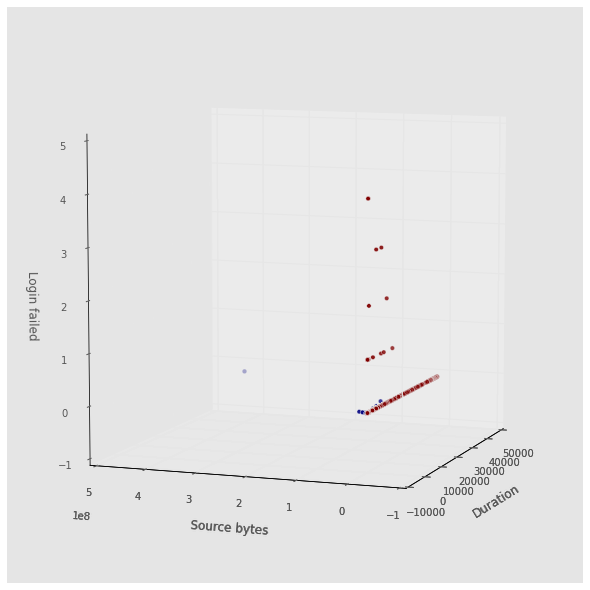

In [13]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(data2[:, 0], data2[:, 1], data2[:, 7], c=labels)

ax.set_xlabel('Duration')
ax.set_ylabel('Source bytes')
ax.set_zlabel('Login failed')

plt.show()

<div class="alert alert-warning">
We are just considering two clusters and therefore it's quite obvious that we get something that doesn't make much sense and as we'll see below the error is huge. Still, we can see the two clusters (one red and the second one blue) and we can observe that the choice of the parameter k=2 was not good.
</div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


<div class="alert alert-warning">
The function `error` computes the error for a single point, thus we have to use the `map` to calculate the total error.
<br>
The formula used is the following one:
<br>
$err = \sum_{i=1}^{n}{\sqrt{(cc_i-x_i)^2}}$
<br>
Where `cc` is the closest centroid and `x` represents the point for which we are computing the error. Both the centroid and the point have n dimensions.
</div>

In [10]:
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return np.power(euclidean_distance(closest_center, point), 2)

In [15]:
WSSSE = data.map(lambda x: error(clusters, x)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 6.37937321457e+18


<div class="alert alert-warning">
As we said before, the result is not good at all, since we got a huge value for the squared error.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

<div class="alert alert-warning">
Here we print all the attacks and the cluster they belong to.
</div>

In [16]:
clusterLabelCount = labelsAndData.map(lambda p: (clusters.predict(p[1]), p[0])).distinct().sortByKey().collect()

for item in clusterLabelCount:
    print(item)

(0, 'smurf.')
(0, 'normal.')
(0, 'pod.')
(0, 'ftp_write.')
(0, 'imap.')
(0, 'neptune.')
(0, 'multihop.')
(0, 'back.')
(0, 'warezclient.')
(0, 'satan.')
(0, 'portsweep.')
(1, 'satan.')
(1, 'guess_passwd.')
(1, 'normal.')
(1, 'nmap.')
(1, 'phf.')
(1, 'warezclient.')
(1, 'spy.')
(1, 'loadmodule.')
(1, 'rootkit.')
(1, 'ipsweep.')
(1, 'buffer_overflow.')
(1, 'perl.')
(1, 'teardrop.')
(1, 'imap.')
(1, 'land.')
(1, 'portsweep.')
(1, 'multihop.')
(1, 'neptune.')
(1, 'warezmaster.')
(1, 'ftp_write.')


<div class="alert alert-warning">
We can notice that there are several attacks (plus the not-an-attack `normal`) present in the both the clusters (e.g. `portsweep`), this is a hint telling us that the choice of `k=2` is not a good one. This makes sense since we have 22 (+1) different types of attacks and all the attacks of the same type are likely to have similar characteristics,  thus we should try to use at least `k=23`.
</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [11]:
n = data.count()

# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=15, initializationMode = "random")
    # calculate mean square error
    return data.map(lambda x: error(clusters, x)).reduce(add)/n

In [27]:
scores = []
k_range = [60,70,80,90,100,110]
for k in k_range:
    score = clusteringScore(data, k)
    scores.append(score)
    print("With k = %3d the score is: %f" %(k, score))

With k =  60 the score is: 139534564346.582642
With k =  70 the score is: 139532396725.545166
With k =  80 the score is: 139538182065.531769
With k =  90 the score is: 139533693884.608276
With k = 100 the score is: 139525979604.244751
With k = 110 the score is: 139533405687.803192


In [83]:
#Just not to run the cell above every time..
scores = [
    139534564346.582642,
    139532396725.545166,
    139538182065.531769,
    139533693884.608276,
    139525979604.244751,
    139533405687.803192
]

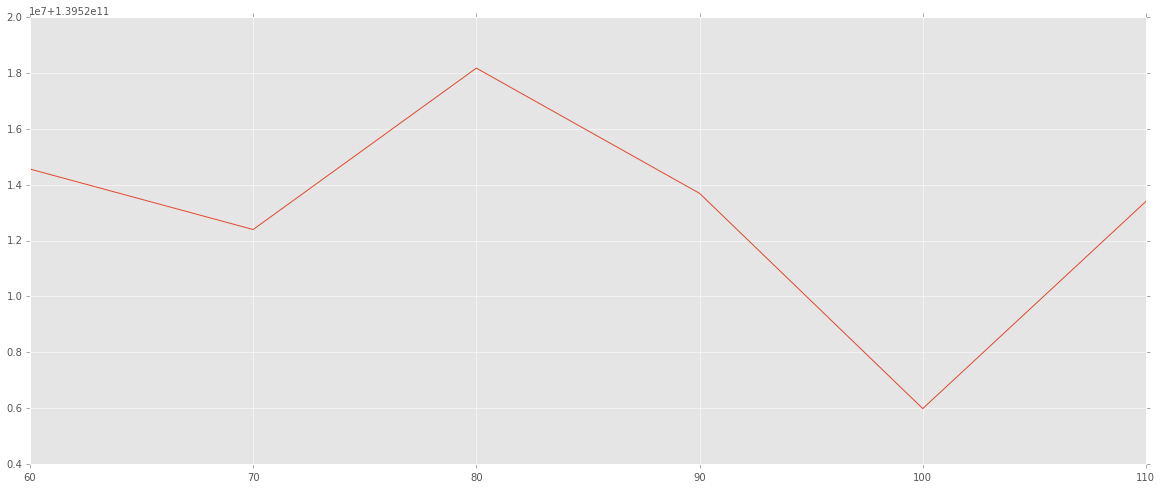

In [29]:
# plot results
plt.plot(scores)
plt.xticks(np.arange(len(scores)), k_range)
plt.show()

In [89]:
#compute the max difference (best-worst) in percentage
best_k  = k_range[scores.index(__builtin__.min(scores))]
worst_k = k_range[scores.index(__builtin__.max(scores))]
print("The best k is", best_k)
print("The worst k is", worst_k)

percentage = (scores[scores.index(__builtin__.max(scores))]-scores[scores.index(__builtin__.min(scores))])\
            /scores[scores.index(__builtin__.min(scores))]
print("The difference (%age) between best and worst is", percentage,"%")

The best k is 100
The worst k is 80
The difference (%age) between best and worst is 8.74565534076823e-05 %


<div class="alert alert-warning">
We can see that the best result is obtained for K = 100, but there isn't a clear behaviour depending on the K. In addition to this we also analyzed the difference between the best and the worst scores (in this range of Ks) and expressing it as percentage of the best one we saw that this difference is really small: in the order of $10^{-5}$
<br>
The point is that we are considering quite big values for k (in the range 60-110), thus we decided to perform the same plot but for different values of k.
</div>

In [31]:
scores = []
k_range = [1, 2, 3, 5, 6, 10, 20, 23, 50, 60, 100]
for k in k_range:
    score = clusteringScore(data, k)
    scores.append(score)
    print("With k = %3d the score is: %f" %(k, score))

With k =   1 the score is: 1302333756836.467041
With k =   2 the score is: 623168716176.315674
With k =   3 the score is: 237842637212.192810
With k =   5 the score is: 233234279262.983734
With k =   6 the score is: 233282720556.738434
With k =  10 the score is: 144421207734.139099
With k =  20 the score is: 144224573603.085419
With k =  23 the score is: 139667615101.453339
With k =  50 the score is: 144231273649.905853
With k =  60 the score is: 139539249155.552826
With k = 100 the score is: 139533853094.345490


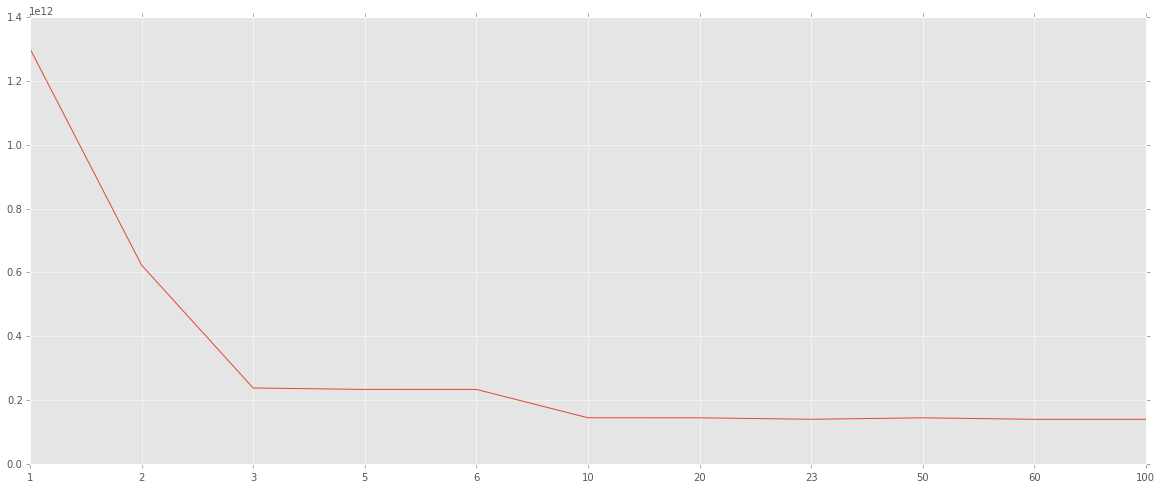

In [32]:
# plot results
plt.plot(scores)
plt.xticks(np.arange(len(scores)), k_range)
plt.show()

<div class="alert alert-warning">
We can see the expected behaviour: the performances are improving for K getting bigger. The point is that when focusing on the range (60, 110) we were focusing only on k-values that led to small changes in the score.
<br><br>
Anyway, the oscillations could look kinda weird, since we could expect that we always improve the score adding a new cluster. This is true if we are adding a new cluster without changing the starting centroids but here this is not the case: indeed, every time we perform a new clustering we generate new random centroids and this lead to the oscillations in the result.
</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [12]:
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    sums = data.reduce(lambda x, y: [a + b for a, b in zip(x, y)])

    # calculate means
    means = data.mean()

    # calculate the sum square of each feature
    # we don't compute it because we don't need it
    #sumSquares = data.aggregate(0, lambda x, y: [a**2 + y for a, b in zip(x, y)])

    # calculate standard deviation of each feature
    stdevs = data.stdev()

    def normalize(point):
        return [((point[i]-means[i]) if (stdevs[i] == 0) else ((point[i]-means[i])/stdevs[i])) for i in range(len(point))]

    return data.map(normalize)

normalizedData = normalizeData(data).cache()

In [13]:
normalizedData.take(5)

[[-0.06683318542420881,
  -0.001720382282287892,
  0.068188435127319452,
  -0.002390846860871979,
  -0.015139173434022768,
  -0.0011034846181947316,
  -0.02652075995496225,
  -0.0043909155847363995,
  2.4427918743642953,
  -0.0020973278346870065,
  -0.0082577083974692041,
  -0.004546461386643566,
  -0.0032845891671851204,
  -0.0095723392157848041,
  -0.0085045784245865279,
  -0.028756112730865285,
  0.0,
  -0.00063897900545820054,
  -0.028911303443117074,
  -1.5754150744340452,
  -1.196243238093317,
  -0.46604261387255441,
  -0.46575557391312739,
  -0.24828577490849504,
  -0.24813035170523645,
  0.53973309269996084,
  -0.2560565202907733,
  -0.20105929643802661,
  -3.6391392588276594,
  -1.7865104366036269,
  -1.8330227339690821,
  -0.28293900018696772,
  -1.2579366383587069,
  -0.1566684879542736,
  -0.46640478356659043,
  -0.46545364052902638,
  -0.25083182898698642,
  -0.2496319657767273],
 [-0.06683318542420881,
  -0.0017766795586854696,
  0.0053245145203947488,
  -0.00239084686087

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [32]:
scoresNormalized = []
k_range = [60,70,80,90,100,110]
for k in k_range:
    score = clusteringScore(normalizedData, k)
    scoresNormalized.append(score)
    print("With k = %3d the score is: %f" %(k, score))

With k =  60 the score is: 13.660351
With k =  70 the score is: 11.743159
With k =  80 the score is: 13.418594
With k =  90 the score is: 13.546758
With k = 100 the score is: 13.344156
With k = 110 the score is: 11.558670


In [91]:
scoresNormalized = [
    13.660351,
    11.743159,
    13.418594,
    13.546758,
    13.344156,
    11.558670
]

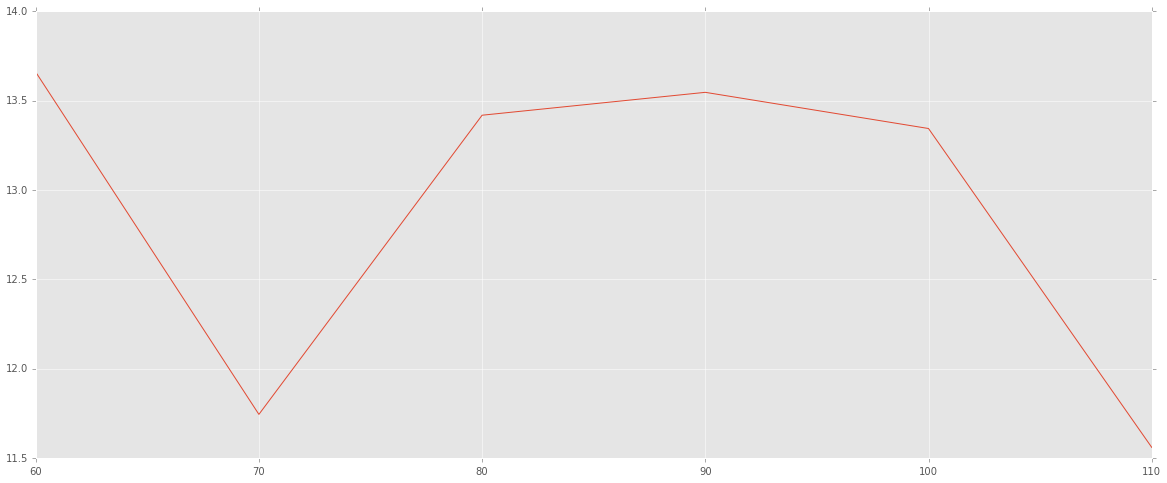

In [92]:
# plot results
plt.plot(scoresNormalized)
plt.xticks(np.arange(len(scoresNormalized)), k_range)
plt.show()

In [93]:
#compute the max difference (best-worst) in percentage
best_k  = k_range[scoresNormalized.index(__builtin__.min(scoresNormalized))]
worst_k = k_range[scoresNormalized.index(__builtin__.max(scoresNormalized))]
print("The best k is", best_k)
print("The worst k is", worst_k)

percentage = (scoresNormalized[scoresNormalized.index(__builtin__.max(scoresNormalized))]\
            -scoresNormalized[scoresNormalized.index(__builtin__.min(scoresNormalized))])\
            /scoresNormalized[scoresNormalized.index(__builtin__.min(scoresNormalized))]
print("The difference (%age) between best and worst is", percentage,"%")

The best k is 110
The worst k is 60
The difference (%age) between best and worst is 0.1818272344482541 %


<div class="alert alert-warning">
We can see that the best result, in this case, is obtained for K = 110, but there isn't a clear behaviour depending on the K, same as it was in the not-normalized one, the problem is the same that we had before: the randomic generation of the starting centroids is the cause of the oscillations. <br>The difference is that this time if we consider the difference between the best and the worst scores we can see that this value is not anymore as small as it was above: now it is 0.18%
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

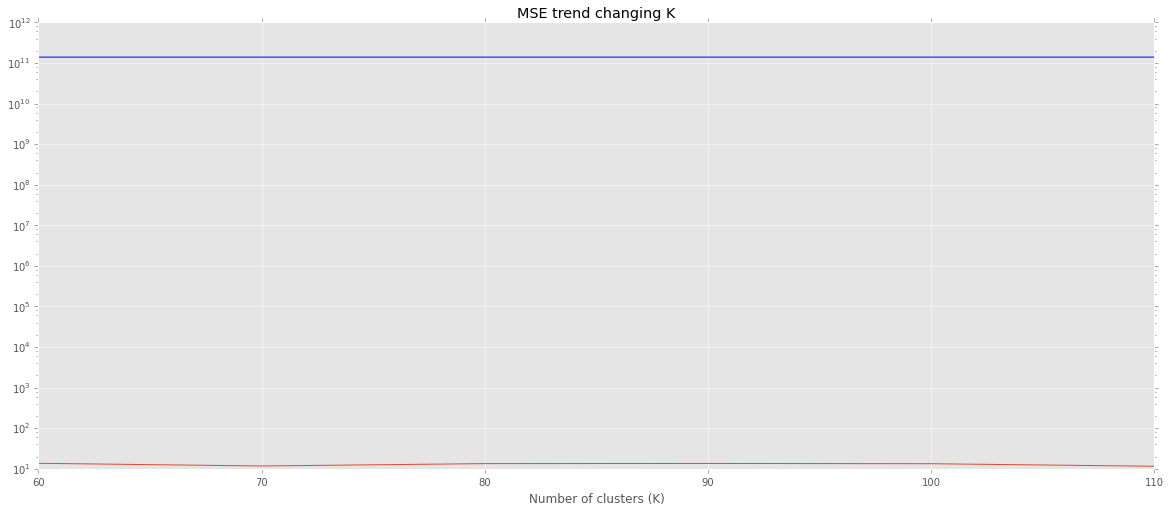

In [94]:
# plot results
fig, ax = plt.subplots()

ax.plot(k_range, scores, color='b')
ax.plot(k_range, scoresNormalized)

plt.title("MSE trend changing K")
plt.yscale("log")
plt.xlabel("Number of clusters (K)")

plt.show()

<div class="alert alert-warning">
If we plot the two results on the same scale, we get an idea of the main effect of normalization: it made all the values smaller and, in this way, it's easier to spot the differences (e.g. the percentages shown above). Anyway, if we want to compare the evolution in the two cases, we should use other plots, we decided to plot:
<ul>
<li>two lines on the same plot in order to see if max/min are correlated</li>
<li>the ratio of the two values in order to see how the values are evolving in each case</li>
</ul>
</div>

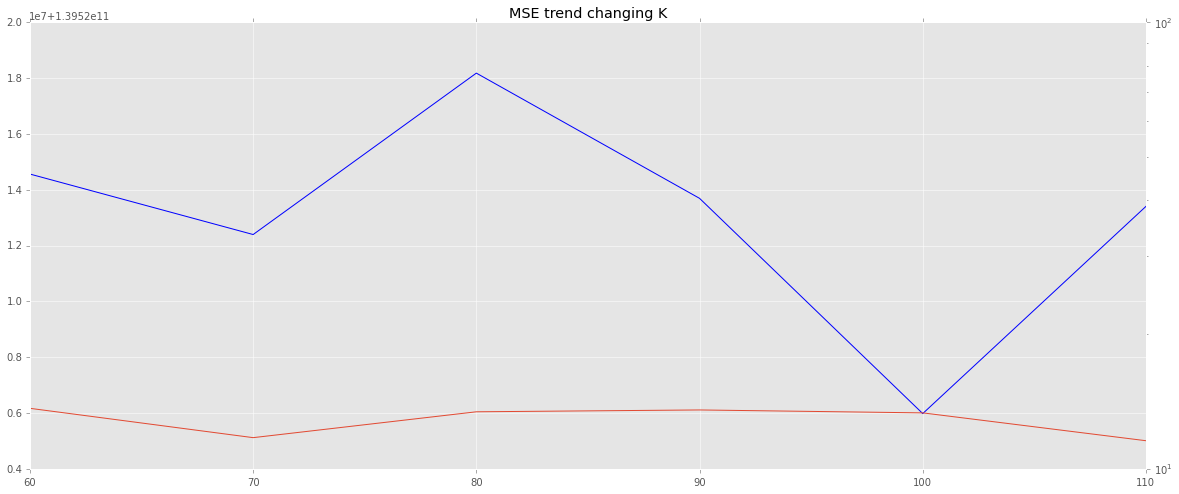

In [43]:
# plot results
fig, ax = plt.subplots()

ax.plot(k_range, scores, color='b')
ax2 = ax.twinx()
ax2.plot(k_range, scoresNormalized)

plt.title("MSE trend changing K")
plt.yscale("log")
plt.xlabel("Number of clusters (K)")

plt.show()

<div class="alert alert-warning">
If we look at them on different scale we can see that there is not a huge relation between maximum points and minimum points, the only exception could be for k=70, where we have a lower value in both the cases. Anyway this happened mainly by chance because of the usual problem due to the randomic generation of the original centroids.
</div>

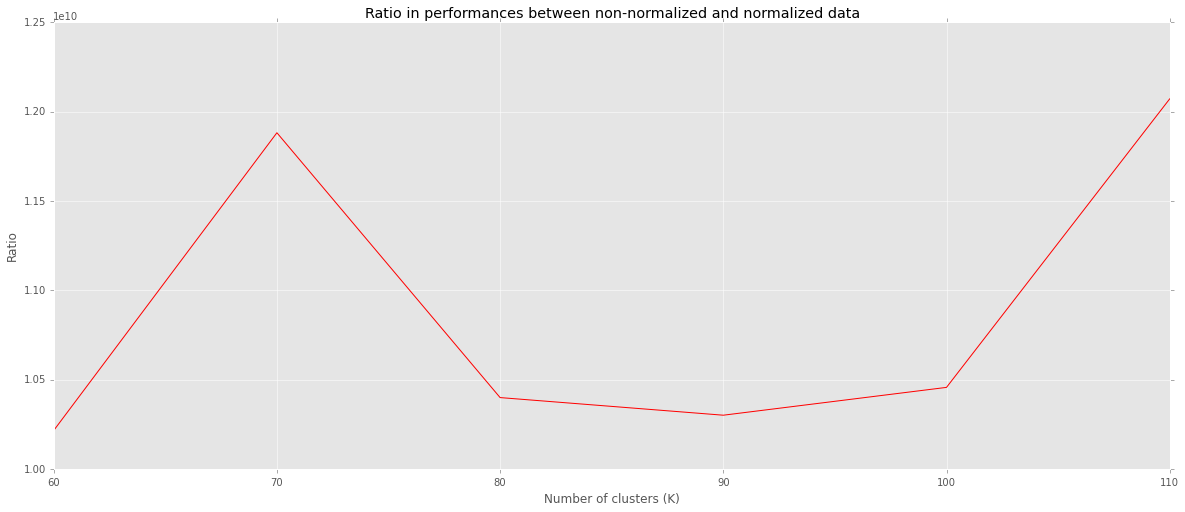

In [44]:
# plot results ratio
scores_ratio = [ scores[i]/scoresNormalized[i] for i in range(len(scores)) ]

plt.plot(k_range, scores_ratio, 'r')
plt.title("Ratio in performances between non-normalized and normalized data")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Ratio")

plt.show()

<div class="alert alert-warning">
Looking at the ratio, we can see that this plot actually does not give any additional information compared to the previous ones (and this was quite disappointing) but this makes sense since in the ratio the numerator is huge compared to the denominator, therefore the result is almost identical to the plot obtained for the normalized scores (just symmetric with respect to x-axis).
</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [14]:
def getCatFeatures(line):
    cols = line.split(',')
    return tuple(cols[1:4])

# create the dictionary: associate each string with unique index

dictionary = raw_data.flatMap(getCatFeatures).distinct().collect()
print("The size of the dictionary is", len(dictionary))

The size of the dictionary is 84


In [15]:
cnt = raw_data.map(getCatFeatures).distinct().count()
listCatFeat = raw_data.map(getCatFeatures).distinct().take(cnt)

print("Number of different values for the 1st cat feat:", len(set([x[0] for x in listCatFeat])))
print("Number of different values for the 2nd cat feat:", len(set([x[1] for x in listCatFeat])))
print("Number of different values for the 3rd cat feat:", len(set([x[2] for x in listCatFeat])))

Number of different values for the 1st cat feat: 3
Number of different values for the 2nd cat feat: 70
Number of different values for the 3rd cat feat: 11


<div class="alert alert-warning">
It's easy to see that the size of the Dictionary created is the same as the sum of the 3 values just printed. Thus, the three different categorical features cannot have the same value.
<div>

In [16]:
def parseLineWithHotEncoding(line):
    cols = line.split(',')
    
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = dictionary.index(cols[1])
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = dictionary.index(cols[2])
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = dictionary.index(cols[3])
    
    # construct the new vector
    vector = ([vector[0], featureOfCol1, featureOfCol2, featureOfCol3] + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector).astype(float)
    
    return (label, vector)

<div class="alert alert-warning">
We created a single dictionary for all the strings (instead of creating a different dictionary for each cathegorical feature) because this choice doesn't affect in any way the classificator and it was easier to work on one dictionary only.
</div>

In [17]:
labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
data = labelsAndData.values().cache()

normalizedData = normalizeData(data).cache()

``` python
###@!SOLUTION@!###
# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()
```

``` python
###@!SOLUTION@!###
normalizedData = normalizeData(data).cache()
```

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [55]:
new_scores = []
new_k_range = [80,90,100,110,120,130,140,150,160]
for k in new_k_range:
    score = clusteringScore(normalizedData, k)
    new_scores.append(score)
    print("With k = %3d the score is: %f" %(k, score))

With k =  80 the score is: 11.364810
With k =  90 the score is: 13.340312
With k = 100 the score is: 12.910041
With k = 110 the score is: 12.243618
With k = 120 the score is: 10.867260
With k = 130 the score is: 12.247295
With k = 140 the score is: 11.577579
With k = 150 the score is: 12.013001
With k = 160 the score is: 10.679739


In [60]:
new_scores = [
    11.364810,
    13.340312,
    12.910041,
    12.243618,
    10.867260,
    12.247295,
    11.577579,
    12.013001,
    10.679739
]

In [63]:
best_k = new_k_range[new_scores.index(__builtin__.min(new_scores))]
print("The best value for k is", best_k)

The best value for k is 160


<div class="alert alert-warning">
While chosing the best k, we should also take into account the **minimum description length** which assign a cost to the generation of a new cluster, in order to avoid overfitting (many clusters really small).
<br>We define the **distortion** for a given k as:
<br>$D_{k} = \sum_{i=1}^{k}{\sum_{x\in{C_i}}{d(x,C_i)}} $
<br>(where all the $C_i$ are the clusters)
<br>and the minimum description length as:
<br>$ MDL = min(D_k + k\cdot C_0) $
<br>where $C_0$ is an arbitrary costant.
<br><br>The problem of this approach is that it would require too much time to be executed (trying several $k$ and $C_0$ and perform the computation for each of them) and therefore we decided to go for the simple solution, even though we are aware of the limitations of our approach.
</div>

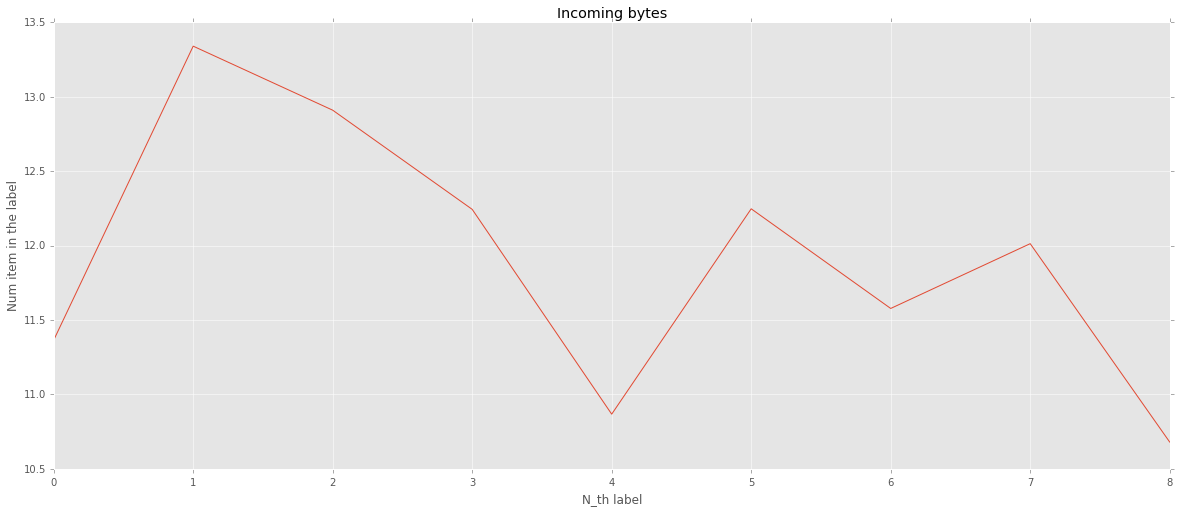

In [57]:
plt.plot(new_scores)
plt.title("Incoming bytes")
plt.xlabel("N_th label")
plt.ylabel("Num item in the label")
plt.show()

<div class="alert alert-warning">
We can see that if we draw a line to approximate the plot this line is decreasing, as we could expect, but we have the usual oscillations due to the randomic generation of initial centroids. Thus we decided also to plot this using another k_range.
</div>

In [79]:
new_scores = []
new_k_range = [1,2,5,10,23,40,80,150]
for k in new_k_range:
    score = clusteringScore(normalizedData, k)
    new_scores.append(score)
    print("With k = %3d the score is: %f" %(k, score))

With k =   1 the score is: 40.000000
With k =   2 the score is: 34.531362
With k =   5 the score is: 36.673687
With k =  10 the score is: 20.005316
With k =  23 the score is: 19.449622
With k =  40 the score is: 16.726425
With k =  80 the score is: 12.624283
With k = 150 the score is: 11.223011


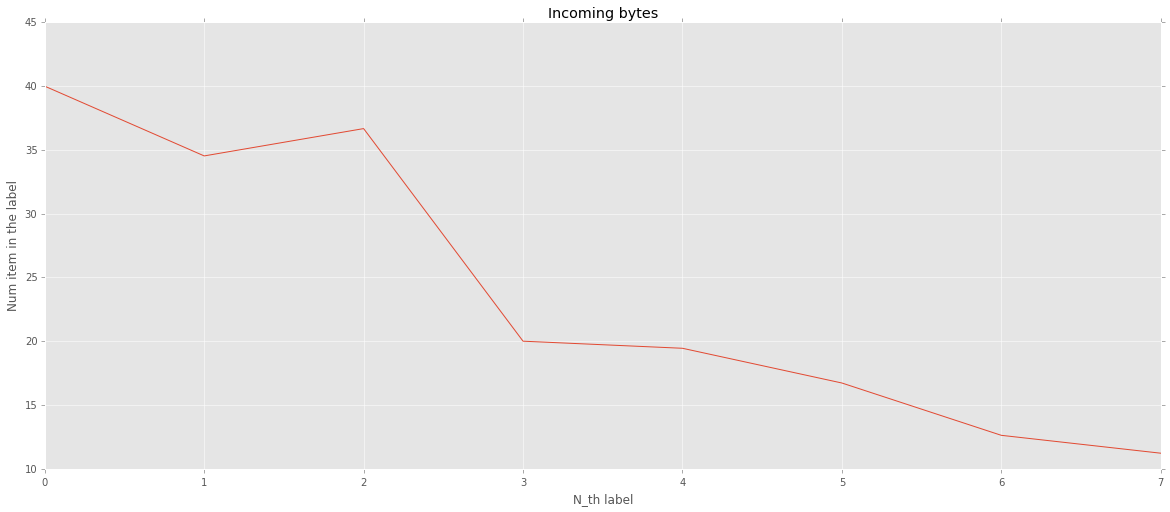

In [81]:
plt.plot(new_scores)
plt.title("Incoming bytes")
plt.xlabel("N_th label")
plt.ylabel("Num item in the label")
plt.show()

<div class="alert alert-warning">
As expected, in this case it's easier to see that increasing the number of clusters the error decreases.
</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [83]:
k = best_k
clusters = KMeans.train(normalizedData, k, maxIterations=10, initializationMode="random")

In [84]:
clustersLabelCount = normalizedData.map(lambda p: (clusters.predict(p), 1)) \
                                   .reduceByKey(lambda a, b: a + b) \
                                   .sortByKey() \
                                   .collect()

#print("Data distribution among centroids:")
#print(clustersLabelCount)

In [85]:
centroids = clusters.centers
distances = normalizedData.map(lambda p: (euclidean_distance(centroids[clusters.predict(p)], p), 1)) \
                          .reduceByKey(lambda a, b: a + b) \
                          .sortByKey(ascending=False)

print("Greatest distances and their frequency:")
print(distances.take(10))

Greatest distances and their frequency:
[(2675.5387911516859, 1), (2030.4278366501464, 1), (1939.7215359332085, 1), (1564.847001434922, 1), (1564.8321286734824, 1), (1465.4441156694641, 1), (1239.7938686950592, 1), (736.18812645095556, 1), (685.80216154687901, 1), (660.38720122446273, 1)]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


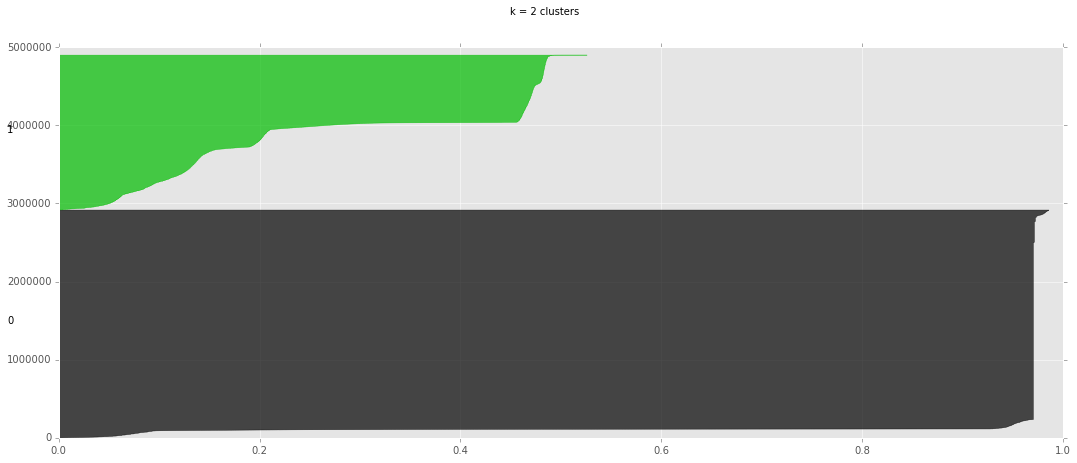

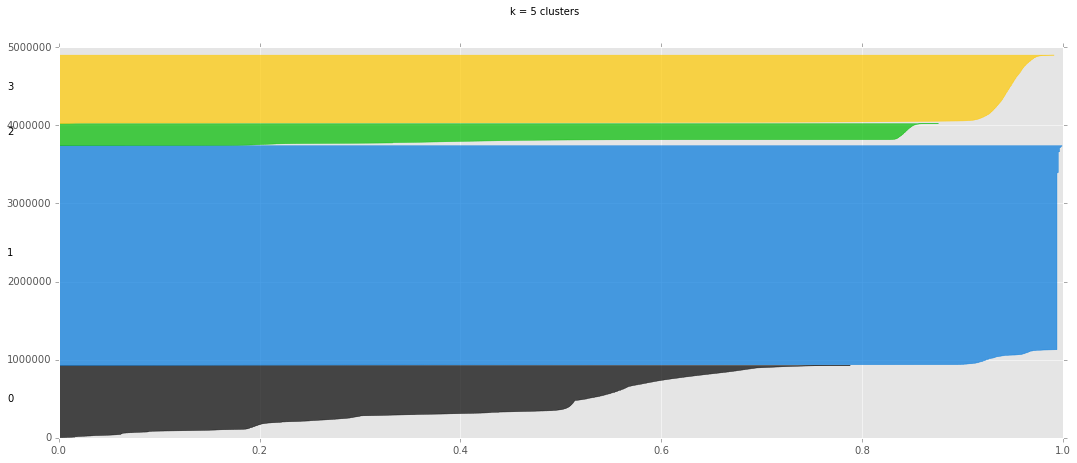

KeyboardInterrupt: 

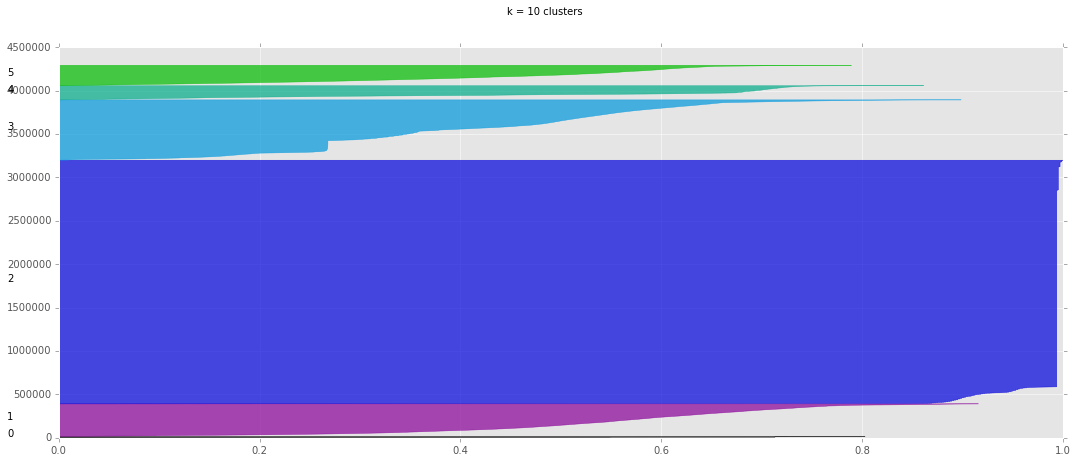

In [69]:
import matplotlib.cm as cm

def silhouette_score(clusters, data):
    def get_cluster(point):
        i = clusters.predict(point)
        return (i, clusters.centers[i], point)
    
    def compute_a_b(x):
        return (x[0], x[1], x[2], 
                euclidean_distance(x[1], x[2]), 
                np.min([euclidean_distance(c, x[2]) for c in clusters.centers if not np.equal(c, x[1]).all()]))
    
    labelled_data = data.map(get_cluster)
    A = labelled_data.map(compute_a_b)
    
    # compute s(i), return RDD
    return A.map(lambda x: (x[0], (x[4] - x[3]) / __builtin__.max(x[4], x[3])))
    

for k in [2, 5, 10, 23, 50]:
    clusters = KMeans.train(normalizedData, k, maxIterations=10, initializationMode="random")
    silhouette_avg = silhouette_score(clusters, normalizedData)

    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)
    fig.suptitle('k = %d clusters' % k)

    y_lower = 10
    for i in range(clusters.k):
        ith_cluster_silhouette_values = silhouette_avg.filter(lambda x: x[0] == i).map(lambda x: x[1]).collect()
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(i / clusters.k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    plt.show()

<div class="alert alert-warning">
From Wikipedia: For each point $i$, let $a(i)$ be the average dissimilarity of $i$ with all other data within the same cluster. We can interpret $a(i)$ as how well $i$ is assigned to its cluster (the smaller the value, the better the assignment).  We then define the average dissimilarity of point $i$ to a cluster $c$ as the average of the distance from $i$ to all points in $c$.

Let $b(i)$ be the lowest average dissimilarity of $i$ to any other cluster, of which $i$ is not a member. The cluster with this lowest average dissimilarity is said to be the "neighbouring cluster" of $i$ because it is the next best fit cluster for point $i$.
We now define a silhouette:

$s(i) = \frac{b(i) - a(i)}{\max\{a(i),b(i)\}}$
<br><br>
In order to make this algorithm feasible, we only consider the dissimilarity between a point within a cluster and its centroid as $a(i)$ and the minimum distance between a point and all the other clusters' centroids as $b(i)$.
<br><br>
In the passage from k=2 to k=5 we can see that we get denser clusters: we have one cluster that is way bigger than the others and it is more dense as well. This cluster is cluster 0 for k=2 and cluster 1 for k=5. We can also see how, increasing the number of k, the newly generated clusters are smaller than the green one in k=2, and thus they are more dense.  
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

<div class="alert alert-warning">
First of all we define our function to perform the requested operation.  
</div>

In [22]:
import random
from operator import add


def sumArrays(a, b):
    c = []
    for x, y in zip(a, b):
        c.append(x + y)
    return c


def computeError(centroids, point):
    closest_center = centroids[find_closest_centroid(point, centroids)]
    return np.power(euclidean_distance(closest_center, point), 2)
    

def rddKMeans(data, k = 2, iterations = 10):
    # select initial centroid from dataset
    centroids = data.sample(False, 0.1, seed=random.seed(1324)).take(k)
    n = data.count()

    iteration = 0
    while iteration < iterations:
        # steps:  * find closest centroid id => maps as (c_id, point)
        #         * for each centroid calculate the amount of points and sum of features
        #         * combine by mapping each cluster id to the average point of the cluster
        new_centroids = data.map(lambda x: (find_closest_centroid(x, centroids), x))\
                            .combineByKey(lambda value: (value, 1),
                                          lambda x, value: (sumArrays(x[0], value), x[1] + 1),
                                          lambda x, y: (sumArrays(x[0], y[0]), x[1] + y[1]))\
                            .map(lambda x: np.array(x[1][0]) / x[1][1])\
                            .collect()

        # if the stop criteria are met, stop the algorithm
        if check_converge(new_centroids, centroids, iteration, 0.1):
            break
        centroids = new_centroids[:]
        iteration += 1
        
    score = data.map(lambda x: computeError(new_centroids, x)).reduce(add) / n
    return new_centroids, score

<div class="alert alert-warning">
And now we can use it to perform the clustering and compute the score. We arbitrarily chose k=6.
</div>

In [23]:
centroids, score = rddKMeans(normalizedData, 6)
print(score)

28.9586776839


<div class="alert alert-warning">
Now we use the "old" function, with the same k.
</div>

In [24]:
score = clusteringScore(normalizedData, 6)
print(score)

22.5584802148


<div class="alert alert-warning">
We can see that the score for our function is worse than the other one, and we also noticed that our function is way slower. We also wanted to perform a loop and compare the two approaches for different k but unfortunately we did not have enough time to run it. Below you can find the code.
</div>

In [ ]:
from time import time

spark_scores = []
spark_times = []
our_scores = []
out_times = []

k_range = [60, 70, 80, 90, 100, 110]

for k in k_range:
    t = time()
    spark_score = clusteringScore(normalizedData, k) # default max iter = 15
    spark_times.append(time() - t)
    spark_scores.append(spark_score)
    
    t = time()
    _, our_score = rddKMeans(normalizedData, k, 15)
    our_times.append(time() - t)    
    our_scores.append(our_score)
    
    print("With k=", k, "spark score is:", spark_score, "our k-means score is:", our_score)
    print('  Timings: spark', spark_times[-1], 'our k-means', our_times[-1])